We will now use a **Odyssey**, a bayesian optimization framework to optimize the color. This will be done in Silico to begin with. The packages for the **SilicoPumpController** are imported as usual.


You can read more about the different classes and methods in the pump_controller module [here](https://www.student.dtu.dk/~s193903/47332/).


Next, the odyssey modules are imported. These include the `Mission`, `SingleGP_Navigator`, `Sobol_Navigator` and `Objective`, and the acquisition functions `EI`, `LogEI`, `PI`, `LogPI` and `UCB`. You can read more about these here:
- [Mission](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/mission/)
- Navigators [SingleGP_Navigator](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/navigators/#odyssey.navigators.SingleGP_Navigator) and its base [Base_Navigator](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/navigators/#odyssey.navigators.Navigator)
- [Sobol Sampler Navigator](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/navigators/#odyssey.navigators.sampler_navigators.Sobol_Navigator)
- [Acquisition Functions](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/acquisition_functions/)
- [Objective](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/objective/#odyssey.objective.Objective)

Some additional packages are also imported.

In [1]:
# Pump Controller
from pump_controller import SilicoPumpController, visualize_rgb, visualize_candidates, read_logfile

# Odyssey
from odyssey.mission import Mission # Mission
from odyssey.navigators import SingleGP_Navigator # Navigator
from odyssey.navigators.sampler_navigators import Sobol_Navigator # Sampler
from odyssey.navigators import ExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound, LogExpectedImprovement, LogProbabilityOfImprovement # Acquisition
from odyssey.objective import Objective # Objective

# Other Packages
import torch
import numpy as np
import pandas as pd    
from IPython import display
from warnings import catch_warnings, simplefilter


/Users/kshitijgambhir/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Self-driving labs/Thesis/Kris/Code/47332-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We again define the `color_difference` function to find the match score between two colors

In [2]:
# Difference between mixed and target colors:
def color_difference(mixed_color, target_color):

    mixed_color = np.array(mixed_color)
    target_color = np.array(target_color)
    # Calculate the sum of root mean squared differences between mixed color and target color
    rmse = np.sqrt(np.mean((mixed_color - target_color)**2, axis=-1))
    return np.sum(rmse)

The silicobot is initialized, and a target color is set.

In [3]:
silicobot = SilicoPumpController(noise_std = 3)

In [4]:
# Set target color
target_mixture = [0.1, 0.2, 0.3, 0.4]
silicobot.change_target(target_mixture)

Silico target changed to [127.02456029 153.81346775  83.01607696]. Created by [0.1, 0.2, 0.3, 0.4].


array([127.02456029, 153.81346775,  83.01607696])

A function `find_score_from_color` is defined. This function is essentially the function to be optimized, as this takes in a color mixture, and outputs a score. For compatibility with **Odyssey**, the `Objective` module from **Odyssey** is used to convert this function.

In [5]:
def find_score_from_color(mixture):
    measured_color = silicobot.mix_color(mixture)
    score = color_difference(measured_color, silicobot.target_color)
    return score

objective = Objective(find_score_from_color)

The **Odyssey** Mission is defined, with 4 `param_dims` (the input mixture values), 1 `output_dims` (the score), and we are trying to minimize this objective, so the `goal` is to descend. We want to initialize the model with 5 initiail points (`num_init_design`) and run the optimization for 10 points (`num_iter`). The `param_space` is the bounds of the input parameters. As each of the colors can be mixed from 0 to 1, we set these values for each color (1e-5 is used instead of 0 to avoid dividing by zero). The `Mission` can then be defined. 


Notice that a folder `missionlogs` has appeared in your directory with a log file with the current timestamp. All optimization points are logged here.

In [6]:
param_dims = 4
output_dims = 1
goals = ['descend']
num_init_design = 5


min = 1e-5

param_space = ([min, 1], [min, 1], [min, 1], [min, 1])

# Define Mission
mission = Mission(name = 'Color Mixing',
                  funcs = [objective],
                  maneuvers = goals,
                  envelope = param_space)

A `Navigator` object is now connected to the mission. This object will use an acquisition function to select attractive points in the parameters space to investigate. Here we have some more parameters such as the initial method and input scaling and data standardization for standardizing data going into the model, and also parameters for the acquisition functions. 


When this navigator is initialized, the number of `num_init_design` defined by the user are sampled using the defined `init_method`. In this case, Sobol Random Sampler is used to sample the initial points. It is important for the model to have some random points to search the space in order to start honing in to the optimum point(s). Refer to the lecture on Bayesian Optimizers for more information about the `Navigator` module. 


Chosing the acquisition function is a task in itself, as this function can balance exploration and exploitation of your data space. As you may see in the imports section, the Acquisition Functions available to you are `ExpectedImprovement`, `LogExpectedImprovement`, `ProbabilityOfImprovement`, `LogProbabilityOfImprovement`, and `UpperConfidenceBound`. These functions can be chosen in the odyssey navigator through the `acqf_function_type`, and their respective parameters can be input in the `acqf_function_params` dictionary. For more information on the parameters of the acquisition functions, refer to [Odyssey Acquisition Functions Reference](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/acquisition_functions/).

In [7]:
# Define Navigator
navigator = SingleGP_Navigator(mission = mission,
                               num_init_design = num_init_design,
                               init_method = Sobol_Navigator(mission = mission),
                               input_scaling = False,
                               data_standardization = False,
                               display_always_max = True,
                               acq_function_type = ProbabilityOfImprovement,
                               acq_function_params = {'best_f': 0.0})

Succesfully appended {'param_1': [0.7517865385845304, 0.3960864148452785, 0.37407618469838055, 0.8082968996995594, 0.4979970960589499], 'param_2': [0.520688430983806, 0.7098489268725552, 0.920138785160929, 0.9153921552737243, 0.7499941023483221], 'param_3': [0.13339497073898093, 0.9594496026736964, 0.7566248162158485, 0.07011057409600355, 0.3692815819337685], 'param_4': [0.8003035888497997, 0.05545825049395674, 0.10499998376294971, 0.40887186979264023, 0.681164017421687], 'objective_1': [50.867160302365626, 58.85425333814284, 47.09849454208956, 41.49339428610955, 22.965791203727818], 'creation_timestamp': '31-05-24 02:36:29'} to missionlogs/Color Mixing-310524_023628.csv


Now that we have some initial points to start from, we can start optimizing. The following is an optimization loop, that runs `num_iter` times. First the next point of investigation (`trajectory`) is suggested by the navigator. We probe this point to get an observation - in this we mix the suggested mixture and calculate the score. Then we relay the information to the mission, log the information and upgrade the model with the new information. The rest of the lines read the logfile of the silicobot, calculate the scores again (in case you decide to change your scoring metric), and visualizes the results. Currently this is done every loop, but this can be done after optimization as well.

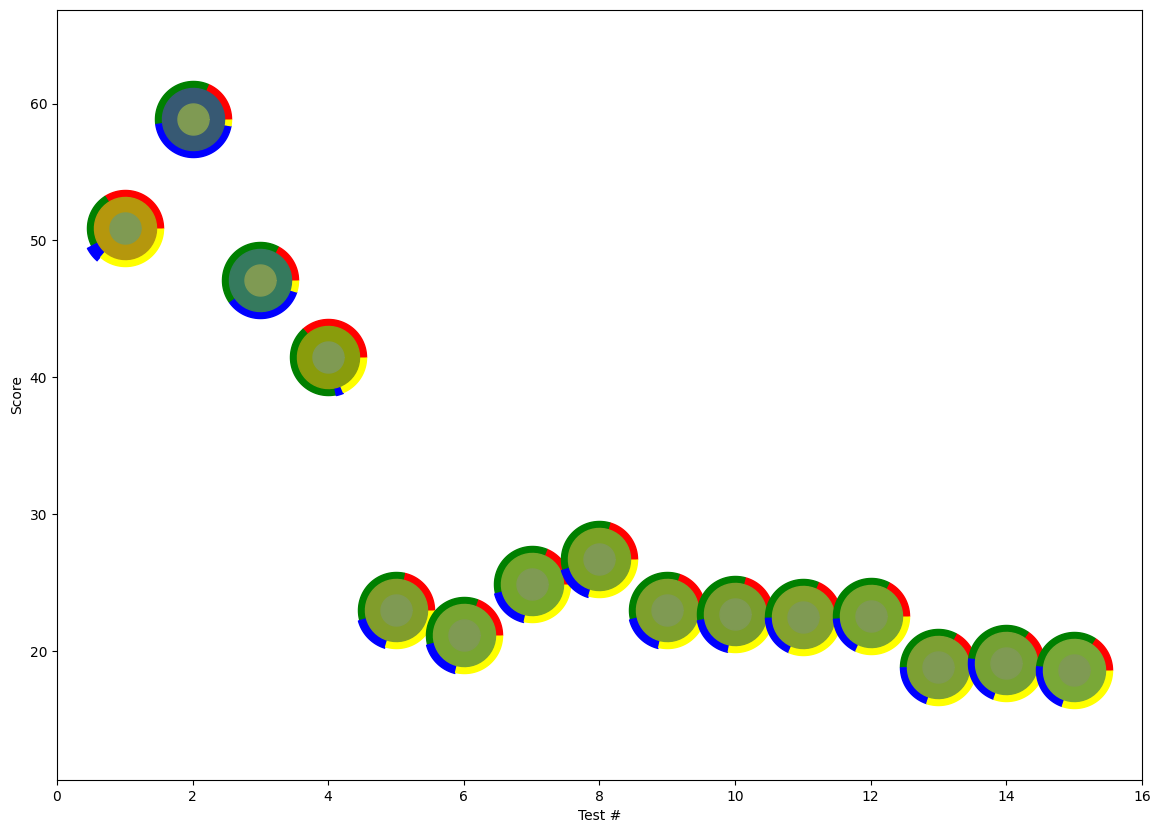

In [8]:
num_iter = 10
while len(mission.train_X) - num_init_design < num_iter:

    with catch_warnings() as w:
        simplefilter('ignore')
        
        trajectory = navigator.trajectory()
        observation = navigator.probe(trajectory, init = False)

        navigator.relay(trajectory, observation)
        navigator.upgrade()

        logs = read_logfile(silicobot.log_file)
        logs['score'] = [color_difference(logs['measurement'][i], logs['target_measurement'][i]) for i in range(len(logs))]

        display.clear_output(wait=True)
        visualize_candidates(logs)
        

The best (in this case lowest) score can be found, along with the corresponding mixture and color measurement. These can then be visualized using the `visualize_rgb` function

In [9]:
best_idx = logs.score.argmin()

best_score = logs.score[best_idx]
best_mixture = logs.mixture[best_idx]
best_color = logs.measurement[best_idx]

print(f"Score {best_score} at mixture {best_mixture} with color {best_color}")


Score 18.585048830131218 at mixture [0.15893620304417116, 0.32522194119313835, 0.21393061636221253, 0.3019112394004781] with color [120.85701720977077, 168.227932691753, 54.90208164122345]


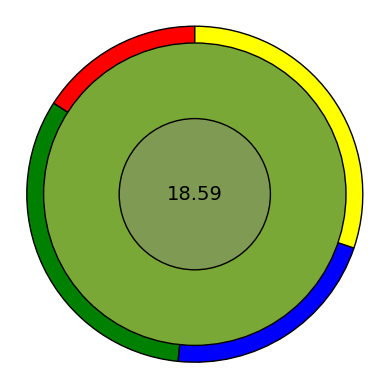

In [10]:
visualize_rgb(mixture = best_mixture,
              rgb = best_color,
              pump_controller = silicobot,
              target = silicobot.target_color,
              score = best_score
              )